# Importing Modules

In [1]:
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt
import os

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

In [3]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications import VGG16
import tensorflow as tf

In [4]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample

# Loading Data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
file_path = kagglehub.dataset_download("farjanakabirsamanta/skin-cancer-dataset")

100%|██████████| 2.58G/2.58G [00:29<00:00, 92.7MB/s]

Extracting files...


In [7]:
file_path = os.path.join(file_path, 'HAM10000_metadata.csv')

In [8]:
df = pd.read_csv(file_path)

In [9]:
label_mapping = {
    'akiec': 'Cancer',  # Actinic keratoses / intraepithelial carcinoma
    'bcc': 'Cancer',    # Basal cell carcinoma
    'mel': 'Cancer',    # Melanoma
    'bkl': 'Normal',    # Benign keratosis-like lesions
    'df': 'Normal',     # Dermatofibroma
    'nv': 'Normal',     # Melanocytic nevi
    'vasc': 'Normal'    # Vascular lesions
}

In [10]:
df['mapped_label'] = df['dx'].map(label_mapping)

In [11]:
df['mapped_label']

,mapped_label
0,Normal
1,Normal
2,Normal
3,Normal
4,Normal
...,...
10010,Cancer
10011,Cancer
10012,Cancer
10013,Cancer


In [12]:
df.shape

(10015, 8)

In [13]:
df.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization,mapped_label
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Normal
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Normal
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Normal
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Normal
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Normal
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear,Normal
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face,Normal
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face,Normal
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back,Normal
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back,Normal


In [14]:
print(df['mapped_label'].value_counts())

mapped_label
Normal    8061
Cancer    1954
Name: count, dtype: int64


# Data Augmentation

In [15]:
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['mapped_label'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.3, stratify=train_df['mapped_label'], random_state=42)

Binary_label_mapping = {'Normal': 0, 'Cancer': 1}
train_df['encoded_label'] = train_df['mapped_label'].map(Binary_label_mapping).astype(str)
val_df['encoded_label'] = val_df['mapped_label'].map(Binary_label_mapping).astype(str)
test_df['encoded_label'] = test_df['mapped_label'].map(Binary_label_mapping).astype(str)

In [16]:
print(train_df['encoded_label'])

2925    1
2438    0
8374    0
5927    0
564     0
       ..
1460    1
8470    0
3388    0
503     0
1244    1
Name: encoded_label, Length: 5608, dtype: object


In [17]:
val_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

In [18]:
print(train_df['image_id'].head())

2925    ISIC_0029545
2438    ISIC_0024370
8374    ISIC_0024721
5927    ISIC_0030622
564     ISIC_0028223
Name: image_id, dtype: object


In [19]:
image_folder = '/content/drive/My Drive/Images/'
image_files = os.listdir(image_folder)

print(image_files[:10])

['ISIC_0028295.jpg', 'ISIC_0028297.jpg', 'ISIC_0028304.jpg', 'ISIC_0028294.jpg', 'ISIC_0028299.jpg', 'ISIC_0028291.jpg', 'ISIC_0028298.jpg', 'ISIC_0028313.jpg', 'ISIC_0028324.jpg', 'ISIC_0028317.jpg']


In [20]:
train_df['image_id'] = train_df['image_id'].apply(lambda x: x + '.jpg')
val_df['image_id'] = val_df['image_id'].apply(lambda x: x + '.jpg')
test_df['image_id'] = test_df['image_id'].apply(lambda x: x + '.jpg')

# Balance with Dataset

Training Data:

In [21]:
target_samples = 8061

class_counts = train_df['mapped_label'].value_counts()

balanced_dfs = []

for label, count in class_counts.items():
    df_class = train_df[train_df['mapped_label'] == label]

    if count > target_samples:
        df_class_balanced = resample(
            df_class,
            replace=False,
            n_samples=target_samples,
            random_state=42
        )
    else:
        df_class_balanced = resample(
            df_class,
            replace=True,
            n_samples=target_samples,
            random_state=42
        )

    balanced_dfs.append(df_class_balanced)

train_df_balanced = pd.concat(balanced_dfs)

train_df_balanced = train_df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

Class Weight:

In [22]:
class__labels = train_df['encoded_label'].unique()

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array(class__labels),
    y=train_df['encoded_label']
)

class_weight_dict = {label: weight for label, weight in zip(class__labels, class_weights)}

print("Class weights:", class_weight_dict)

Class weights: {'1': 2.563071297989031, '0': 0.6211785556047851}


In [23]:
print(train_df_balanced['mapped_label'].value_counts())

mapped_label
Normal    8061
Cancer    8061
Name: count, dtype: int64


In [52]:
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='/content/drive/My Drive/Images/',
    x_col='image_id',
    y_col='encoded_label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory='/content/drive/My Drive/Images/',
    x_col='image_id',
    y_col='encoded_label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='/content/drive/My Drive/Images/',
    x_col='image_id',
    y_col='encoded_label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 5608 validated image filenames belonging to 2 classes.
Found 2404 validated image filenames belonging to 2 classes.
Found 2003 validated image filenames belonging to 2 classes.


# Building Model

In [53]:
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
#kernel_regularizer=l2(0.001)
#x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

In [54]:
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Checking Some Issue

In [28]:
steps_per_epoch = len(train_generator)
validation_steps = len(val_generator)

In [29]:
print("steps of len for train_generator: ",steps_per_epoch)
print("steps of len for val_generator: ",validation_steps)

steps of len for train_generator:  351
steps of len for val_generator:  151


In [30]:
missing_labels = val_df['encoded_label'].isnull().sum()
print(f"Number of missing labels: {missing_labels}")

Number of missing labels: 0


In [31]:
label_distribution = val_df['encoded_label'].value_counts()
print(f"Label distribution:\n{label_distribution}")

Label distribution:
encoded_label
0    1935
1     469
Name: count, dtype: int64


In [32]:
print(val_df['encoded_label'].unique())

['0' '1']


In [33]:
validation_steps = len(val_df) // val_generator.batch_size
print(f"Validation Steps: {validation_steps}")

Validation Steps: 150


In [34]:
print(val_df.shape)

(2404, 9)


In [35]:
batch = next(val_generator)
print(batch[0].shape, batch[1].shape)

(16, 224, 224, 3) (16,)


----------------------------------

# Training

In [36]:
steps_epoch = len(train_df_balanced) // train_generator.batch_size
val_steps = len(val_df) // val_generator.batch_size

In [55]:
len_steps_epoch = len(train_generator) + 1
len_val_steps = len(val_generator) + 1

In [56]:
print(steps_epoch)
print(val_steps)

1007
150


In [57]:
print(len_steps_epoch)
print(len_val_steps)

177
77


In [58]:
epochs = 15

history = model.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=len_steps_epoch,
    validation_steps=len_val_steps,
    class_weight=class_weight_dict,
    epochs=epochs
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


176/177 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7362 - loss: 0.5642

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


177/177 ━━━━━━━━━━━━━━━━━━━━ 553s 3s/step - accuracy: 0.7365 - loss: 0.5635 - val_accuracy: 0.8095 - val_loss: 0.3943
Epoch 2/15
177/177 ━━━━━━━━━━━━━━━━━━━━ 550s 3s/step - accuracy: 0.8400 - loss: 0.3551 - val_accuracy: 0.8199 - val_loss: 0.3758
Epoch 3/15
177/177 ━━━━━━━━━━━━━━━━━━━━ 473s 3s/step - accuracy: 0.8263 - loss: 0.3513 - val_accuracy: 0.8307 - val_loss: 0.3689
Epoch 4/15
177/177 ━━━━━━━━━━━━━━━━━━━━ 501s 3s/step - accuracy: 0.8517 - loss: 0.3360 - val_accuracy: 0.8299 - val_loss: 0.3663
Epoch 5/15
177/177 ━━━━━━━━━━━━━━━━━━━━ 506s 3s/step - accuracy: 0.8415 - loss: 0.3331 - val_accuracy: 0.8369 - val_loss: 0.3609
Epoch 6/15
177/177 ━━━━━━━━━━━━━━━━━━━━ 481s 3s/step - accuracy: 0.8565 - loss: 0.3208 - val_accuracy: 0.8353 - val_loss: 0.3541
Epoch 7/15
177/177 ━━━━━━━━━━━━━━━━━━━━ 520s 3s/step - accuracy: 0.8502 - loss: 0.3137 - val_accuracy: 0.8365 - val_loss: 0.3608
Epoch 8/15
177/177 ━━━━━━━━━━━━━━━━━━━━ 493s 3s/step - accuracy: 0.8515 - loss: 0.3239 - val_accuracy: 0.840

# Evaluation

In [59]:
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

76/76 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.8406 - loss: 0.3494
Validation Loss: 0.3470, Validation Accuracy: 0.8419


In [60]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=None)

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

63/63 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.8293 - loss: 0.3566
Test Accuracy: 84.47%
Test Loss: 0.3250


Classification Report:

In [61]:
#predictions = model.predict(test_generator, steps=None)

y_pred = np.argmax(model.predict(test_generator), axis=1)
#predicted_classes = (predictions > 0.5).astype(int)

actual_labels = test_generator.classes

63/63 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step


In [62]:
class_labels = list(test_generator.class_indices.keys())

print("Classification Report:\n", classification_report(actual_labels, y_pred, target_names=class_labels))

conf_matrix = confusion_matrix(actual_labels, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Classification Report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89      1612
           1       0.00      0.00      0.00       391

    accuracy                           0.80      2003
   macro avg       0.40      0.50      0.45      2003
weighted avg       0.65      0.80      0.72      2003

Confusion Matrix:
 [[1612    0]
 [ 391    0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Visualization

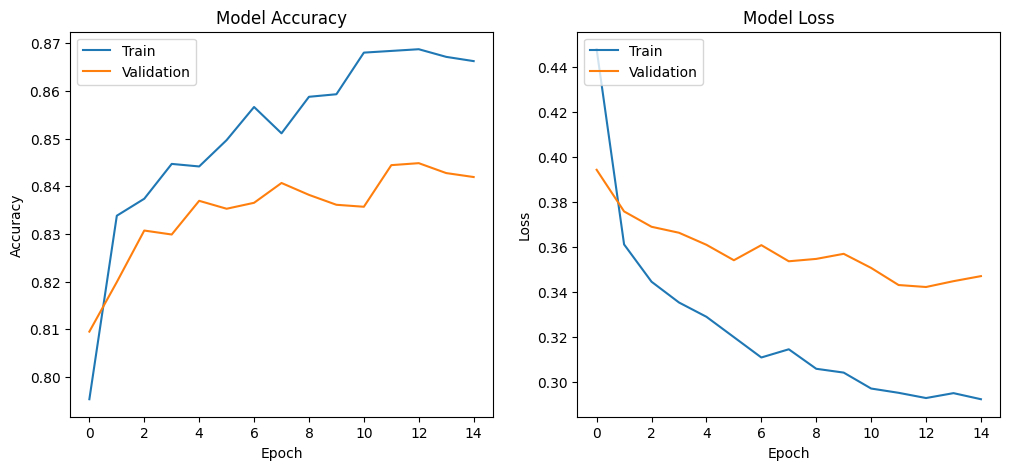

In [63]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Saving Model

In [64]:
model.save('skin_cancer_model.h5')